In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
from matplotlib import pyplot as plt
import json

from kmv import insolvency_probability

In [2]:
all_stock_data = yf.download(['WMT', 'CCC.WA'], start='2023-06-12', end='2024-06-13')
raw_close = pd.DataFrame({'ccc': all_stock_data.Close['CCC.WA'], 'wmt': all_stock_data.Close.WMT})
close = raw_close.interpolate("linear")
log_std = (np.log(close) - np.log(close.shift(1))).std()

[*********************100%%**********************]  2 of 2 completed


In [35]:
wmt = yf.Ticker("WMT")

wmt_params = {"L": wmt.info["totalDebt"],
              "r": (4.34 / 100 + 1) ** (1 / 250) - 1,
              "k": (wmt.info["dividendYield"] + 1) ** (1 / 250) - 1,
              "sigma_E": log_std.wmt,
              "E": wmt.info["currentPrice"] * wmt.info["sharesOutstanding"],
              "market_cap": wmt.info['marketCap']}

with open("parameters\\wmt_parameters.json", "w") as outfile:
    json.dump(wmt_params, outfile, indent=4)

In [36]:
ccc = yf.Ticker("CCC.WA")

ccc_params = {"L": ccc.info["totalDebt"],
              "r": (5.75 / 100 + 1) ** (1 / 250) - 1,
              "k": 0,
              "sigma_E": log_std.ccc,
              "E": ccc.info["currentPrice"] * ccc.info["sharesOutstanding"],
              "market_cap": ccc.info['marketCap']}

with open("parameters\\ccc_parameters.json", "w") as outfile:
    json.dump(ccc_params, outfile, indent=4)

In [26]:
wmt_probability, wmt_solution = insolvency_probability(250, wmt_params)
wmt_probability

C:\Projects\PyProjects\risk\projekt5\kmv.py:15: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  solution = fsolve(


0.0

In [27]:
ccc_probability, ccc_solution = insolvency_probability(250, ccc_params)
ccc_probability

0.0002905408916527019

## Wykresy

### Wykres $DP_t$

In [31]:
%%capture

t = np.arange(0, 5, 0.05)
wmt_probs = [insolvency_probability(i * 250, wmt_params)[0] for i in t]
plt.plot(t, wmt_probs)
plt.xlabel('t, [rok]')
plt.ylabel('prawdopodobieństwo niewypłacalności')
plt.grid()
plt.savefig("plots\\wmt.png")

In [32]:
%%capture

ccc_probs = [insolvency_probability(i * 250, ccc_params)[0] for i in t]
plt.plot(t, ccc_probs)
plt.xlabel('t, [rok]')
plt.ylabel('prawdopodobieństwo niewypłacalności')
plt.grid()
plt.savefig("plots\\ccc.png")

### Wykres $V_T$

In [132]:
T = np.arange(1, 5 * 250, 1)
N = 3000

In [133]:
noise = np.array([np.random.normal(size=len(T)) for _ in range(N)]).T

wmt_sigma, wmt_v = wmt_solution
VT_trajectories = np.array([wmt_v * np.exp((wmt_params["r"] - wmt_params["k"] - wmt_sigma ** 2 / 2) * t + wmt_sigma * np.sqrt(t) * e) for t , e in zip(T, noise)]).T

In [134]:
alpha = 0.05
quantiles_lower = np.quantile(VT_trajectories, alpha, axis=0)
quantiles_upper = np.quantile(VT_trajectories, 1 - alpha/2, axis=0)

v0 = wmt_v * np.exp((wmt_params["r"] - wmt_params["k"] - wmt_sigma ** 2 / 2) * T)

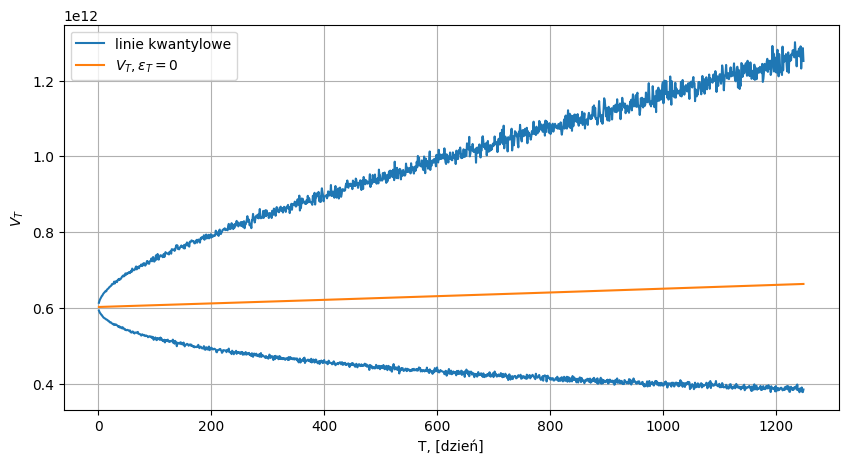

In [137]:
plt.figure(figsize=(10, 5))
line1, = plt.plot(T, quantiles_lower, c='C0')
plt.plot(T, quantiles_upper, c='C0')
plt.grid()
line2, = plt.plot(T, v0, c='C1')
plt.xlabel("T, [dzień]")
plt.ylabel("$V_T$")
plt.legend([line1, line2], ['linie kwantylowe', '$V_T, \epsilon_T=0$'])
plt.savefig("plots\\wmt_vt.png")

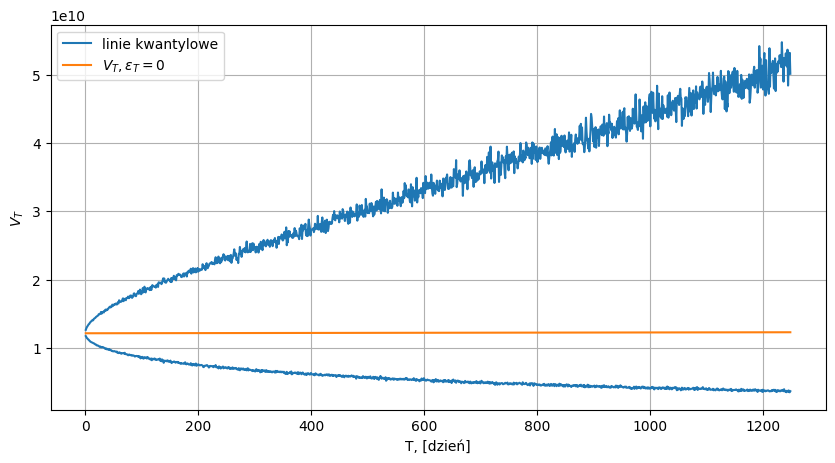

In [139]:
ccc_sigma, ccc_v = ccc_solution
VT_trajectories = np.array(
    [ccc_v * np.exp((ccc_params["r"] - ccc_params["k"] - ccc_sigma ** 2 / 2) * t + ccc_sigma * np.sqrt(t) * e) for t, e
     in zip(T, noise)]).T
alpha = 0.05
quantiles_lower = np.quantile(VT_trajectories, alpha, axis=0)
quantiles_upper = np.quantile(VT_trajectories, 1 - alpha / 2, axis=0)

v0 = ccc_v * np.exp((ccc_params["r"] - ccc_params["k"] - ccc_sigma ** 2 / 2) * T)
plt.figure(figsize=(10, 5))
line1, = plt.plot(T, quantiles_lower, c='C0')
plt.plot(T, quantiles_upper, c='C0')
plt.grid()
line2,  = plt.plot(T, v0, c='C1')
plt.xlabel("T, [dzień]")
plt.ylabel("$V_T$")
plt.legend([line1, line2], ['linie kwantylowe', '$V_T, \epsilon_T=0$'])

plt.savefig("plots\\ccc_vt.png")